In [31]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D, proj3d
from matplotlib.patches import FancyArrowPatch
from sklearn.cluster import KMeans
from scipy.cluster import vq
    # Gives libraries to create 3D plots

In [32]:
"""First class designation"""
vc1 = [0,1,2]
    # the means of each dimension
cov_mat1 = np.array([[1,0,0],[0,1,0],[0,0,1]])
    # The covariances of the dimensions
cla1 = np.random.multivariate_normal(vc1, cov_mat1, 20).T
    # Creates a random 20 samples with the given dim means and covariance
assert cla1.shape == (3, 20), "Not the correct dimensions"

"""Second class designation"""
vc2 = [1,1,1]
    # the means of each dimension
cov_mat2 = np.array([[1,0,0],[0,1,0],[0,0,1]])
    # The covariances of the dimensions
cla2 = np.random.multivariate_normal(vc2, cov_mat2, 20).T
    # Creates a random 20 samples with the given dim means and covariance
assert cla2.shape == (3, 20), "Not the correct dimensions"

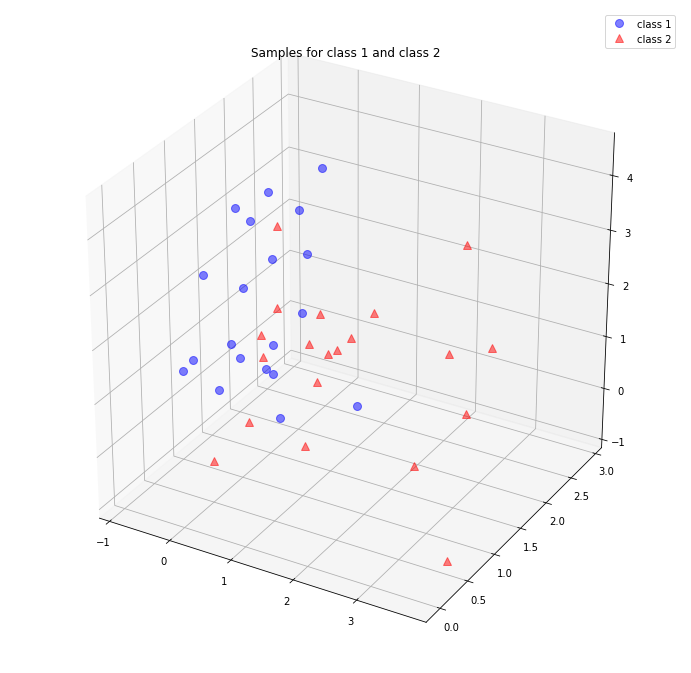

In [33]:
samplePlot = plt.figure(figsize=(12,12))
    # Changes how large the plot is to see things
ax = samplePlot.add_subplot(111, projection='3d')
    # Creates 3 axis' in 3d
plt.rcParams['legend.fontsize'] = 10   
ax.plot(cla1[0,:], cla1[1,:], cla1[2,:], 'o', markersize=8, color='blue', alpha=0.5, label='class 1')
ax.plot(cla2[0,:], cla2[1,:], cla2[2,:], '^', markersize=8, alpha=0.5, color='red', label='class 2')
    #Plots the x,y,and z of each sample in the different clases

plt.title('Samples for class 1 and class 2')
ax.legend(loc='upper right')
plt.show()

# Step 1

Ignore the class labels. Here, I'll merge the two samples into a single 3x40 matrix

In [34]:
samples = np.concatenate((cla1, cla2), axis=1)
assert samples.shape == (3,40), 'Matrix is not the right shape, error'

# Step 2
Compute the d-dimensional mean vector. So, compute the vector consisting of the means for every direction.

In [35]:
xMean = np.mean(samples[0,:])
yMean = np.mean(samples[1,:])
zMean = np.mean(samples[2,:])
    # Uses a function to compute and store the mean of that dim by taking
    # only sample points of that direction
    
meanVector = np.array([[xMean],[yMean],[zMean],])
print(meanVector)

[[ 0.86898501]
 [ 1.18104777]
 [ 1.67011884]]


# Step 3
Compute the **scatter matrix**, or the **covariance matrix**, of the entire dataset. Because we have 3 dimensions, it should be 3x3. Scatter matrix is different to covariance only in that they are scaled differently so **eigenspaces** are the same.

In [36]:
covMatrix = np.cov(samples)
    # Handy function, computes the covariance of all the different dims
print(covMatrix)

[[ 1.1718577  -0.03955206 -0.43756978]
 [-0.03955206  0.63251296 -0.06984778]
 [-0.43756978 -0.06984778  1.60524414]]


# Step 4
Compute the eigenvectors and eigenvalues of space.

**eigenvector** - **v** is an eigenvector of T if T(**v**) = lambda**v**

**eigenvalue** - The lambda in the above equation, a scalar

In [37]:
eigVal, eigVec = np.linalg.eig(covMatrix)

for i in range(len(eigVal)):
    eigVecShow = eigVec[:,i].reshape(1,3).T
    # New array consist of eigVec Matrix for only certain dim
    
    print(eigVecShow)
    print(eigVal[i], '\n')
    # Prints the eigenvector and eigen value for each of the dims
    

[[ 0.52520655]
 [ 0.03101217]
 [-0.85040951]]
1.87803112887 

[[-0.83010022]
 [ 0.23865761]
 [-0.50396048]]
0.917576984091 

[[-0.18732779]
 [-0.97060846]
 [-0.15108775]]
0.614006686093 



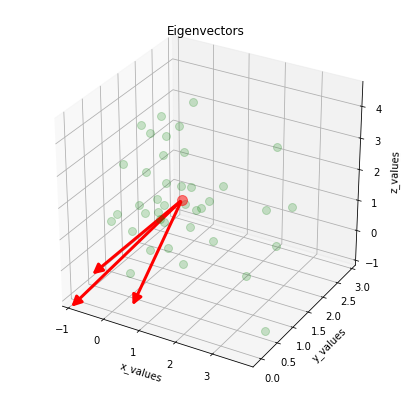

In [38]:
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

eigFig = plt.figure(figsize=(7,7))
ax = eigFig.add_subplot(111, projection='3d')

ax.plot(samples[0,:], samples[1,:], samples[2,:], 'o', markersize=8, color='green', alpha=0.2)
ax.plot([xMean], [yMean], [zMean], 'o', markersize=10, color='red', alpha=0.5)
for v in eigVec.T:
    a = Arrow3D([xMean, v[0]], [yMean, v[1]], [zMean, v[2]], mutation_scale=20, lw=3, arrowstyle="-|>", color="r")
    ax.add_artist(a)
ax.set_xlabel('x_values')
ax.set_ylabel('y_values')
ax.set_zlabel('z_values')

plt.title('Eigenvectors')

plt.show()

# Have to look at deeper later

# Step 5

Sort the eigenvectors by decreasing eigenvalues. Then, choose k eigenvectors with the largest eigenvalues to form a (d x k) dim matrix. Eigenvectors with the smallest eigenvalues have the least info about the distribution of the data so they can be dropped because they are "fluff."

Every column will represent an eigenvector.

In [39]:
eigPairs = [(np.abs(eigVal[i]), eigVec[:,i]) for i in range(len(eigVal))]
    # Takes the absolute value of the eigValue and pairs it to its eigVec
    # Puts these pairs in a tuple? Means you can't change it
eigPairs.sort(key=lambda x: x[0], reverse = True)
    # Can probably find better way to sort this, like descending function

for i in eigPairs:
    print(i[0])

1.87803112887
0.917576984091
0.614006686093


In [40]:
matrixW = np.hstack((eigPairs[0][1].reshape(3,1), eigPairs[1][1].reshape(3,1)))
    # Matrix of the value corresponding to the key of the eigenvalue we choose
    # Here, we picked k=2
print(matrixW)

[[ 0.52520655 -0.83010022]
 [ 0.03101217  0.23865761]
 [-0.85040951 -0.50396048]]


# Step 6
Use the (dxk) matrix W above to transform samples onto the new subspace. Uses the equation

y=(W^T)x(**z**)

z == a dx1 dim vector representing a sample

y == the transformed kx1 dim sample in the new subspace

In [41]:
newSample = matrixW.T.dot(samples)
    # Computes the above equation
assert newSample.shape == (2,40), 'Matrix is not 2x40'

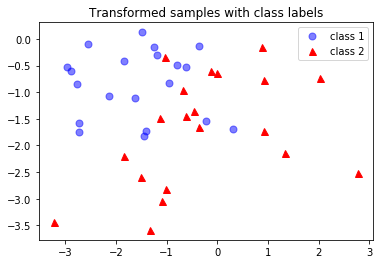

In [42]:
plt.plot(newSample[0,0:20], newSample[1,0:20], 'o', markersize=7, color='blue', alpha=.5, label='class 1')
plt.plot(newSample[0,20:40], newSample[1,20:40], '^', markersize=7, color='red', label='class 2')
    # Alpha changes color saturation
plt.legend()
plt.title('Transformed samples with class labels')

plt.show()

In [43]:
newS = newSample.T
print(newS.shape)

coop = KMeans(n_clusters=5).fit_predict(newS)
print(coop)
centroids, variance = vq.kmeans(newS,5)
print(centroids)

(40, 2)
[1 3 3 1 3 1 3 3 1 3 0 1 1 1 1 1 3 4 4 0 2 4 2 2 2 0 0 4 2 4 0 4 2 0 0 1 4
 4 0 4]
[[-0.77116431 -0.43934584]
 [-1.60155729 -2.65604862]
 [-2.46686633 -0.88655403]
 [-0.41104284 -1.5245717 ]
 [ 1.47881014 -1.33974843]]
